Code references:
1)sklearn 
https://scikit-learn.org/stable/modules/model_evaluation.html
2)Tensorflow tokenizer
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
3)Tensorflow models:
https://www.tensorflow.org/tutorials/keras/text_classification
4)tensorflow Simple RNN
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
5)padding and sequencing:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
6)Tensorflow tutorials
https://www.tensorflow.org/tutorials

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None 
nlp_data=pd.read_csv('/content/drive/Shareddrives/NLP_project_materials/complaints.csv')

In [ ]:
nlp_data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-10-06,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",MD,21207,NaN,NaN,Web,2021-10-06,In progress,Yes,NaN,4783820
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,NaN,NaN,Referral,2019-08-15,Closed with explanation,Yes,NaN,3342290


In [ ]:
import datetime as dt

nlp_data['Date received'] = pd.to_datetime(nlp_data['Date received'], format='%Y-%m-%d')

In [ ]:
nlp_data_filter = nlp_data.loc[(nlp_data['Date received'] >= '2021-01-01')]

In [ ]:
nlp_data_filter.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
3,2021-10-06,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",MD,21207,NaN,NaN,Web,2021-10-06,In progress,Yes,NaN,4783820
7,2021-09-30,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CO,80504,NaN,NaN,Web,2021-09-30,Closed with explanation,Yes,NaN,4768293
8,2021-10-06,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",AL,36502,NaN,NaN,Web,2021-10-06,In progress,Yes,NaN,4783868
23,2021-09-14,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,Home Point Financial Corporation,CA,918XX,"Older American, Servicemember",NaN,Web,2021-09-30,Closed with explanation,Yes,NaN,4719600
24,2021-10-01,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,NaN,NaN,Tate and Kirlin Assoc,FL,33408,NaN,Other,Web,2021-10-01,Closed with explanation,Yes,NaN,4770127


In [ ]:
lab=nlp_data_filter['Product'].unique().tolist()

In [ ]:
lab

['Credit reporting, credit repair services, or other personal consumer reports',
 'Credit card or prepaid card',
 'Mortgage',
 'Debt collection',
 'Student loan',
 'Checking or savings account',
 'Vehicle loan or lease',
 'Money transfer, virtual currency, or money service',
 'Payday loan, title loan, or personal loan']

In [ ]:
re_dict={'Credit reporting, credit repair services, or other personal consumer reports':'Credit reporting',
'Money transfer, virtual currency, or money service':'retail_banking',
'Payday loan, title loan, or personal loan':'mortgages_and_loans',
'Student loan':'mortgages_and_loans',
'Checking or savings account':'retail_banking',
'Mortgage':'mortgages_and_loans',
'Vehicle loan or lease':'mortgages_and_loans',
'Credit card or prepaid card':'credit_card',
'Debt collection':'debt_collection'}

In [ ]:
nlp_data_filter['Product'].replace(re_dict,inplace=True)

In [ ]:
nlp_data_filter.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
3,2021-10-06,Credit reporting,Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",MD,21207,NaN,NaN,Web,2021-10-06,In progress,Yes,NaN,4783820
7,2021-09-30,credit_card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CO,80504,NaN,NaN,Web,2021-09-30,Closed with explanation,Yes,NaN,4768293
8,2021-10-06,Credit reporting,Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",AL,36502,NaN,NaN,Web,2021-10-06,In progress,Yes,NaN,4783868
23,2021-09-14,mortgages_and_loans,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,Home Point Financial Corporation,CA,918XX,"Older American, Servicemember",NaN,Web,2021-09-30,Closed with explanation,Yes,NaN,4719600
24,2021-10-01,debt_collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,NaN,NaN,Tate and Kirlin Assoc,FL,33408,NaN,Other,Web,2021-10-01,Closed with explanation,Yes,NaN,4770127


In [ ]:
nlp_data_filter['Product'].unique()

array(['Credit reporting', 'credit_card', 'mortgages_and_loans',
       'debt_collection', 'retail_banking'], dtype=object)

In [ ]:
nlp_data_filter.drop(['Date received', 'Issue','Company public response','Company public response','Company','State','ZIP code','Tags','Consumer consent provided?','Submitted via','Date sent to company','Company response to consumer','Submitted via','Date sent to company','Company response to consumer','Timely response?','Consumer disputed?','Complaint ID','Sub-product','Sub-issue'], axis=1, inplace=True)

In [ ]:
nlp_data_filter.head()

,Product,Consumer complaint narrative
3,Credit reporting,NaN
7,credit_card,NaN
8,Credit reporting,NaN
23,mortgages_and_loans,NaN
24,debt_collection,NaN


In [ ]:
nlp_data_filter.dropna(subset = ['Consumer complaint narrative'], inplace=True)
nlp_data_filter.head()

,Product,Consumer complaint narrative
77,debt_collection,I received a collections notice dated XX/XX/XX...
130,Credit reporting,ATTN Collections Dept I am submitting a compla...
202,mortgages_and_loans,Despite my forbearance having ended months ago...
215,mortgages_and_loans,I have made several payments that have been de...
223,mortgages_and_loans,About three years ago I attempted to assume gr...


In [ ]:
nlp_data_filter.head()

,Product,Consumer complaint narrative
77,debt_collection,I received a collections notice dated XX/XX/XX...
130,Credit reporting,ATTN Collections Dept I am submitting a compla...
202,mortgages_and_loans,Despite my forbearance having ended months ago...
215,mortgages_and_loans,I have made several payments that have been de...
223,mortgages_and_loans,About three years ago I attempted to assume gr...


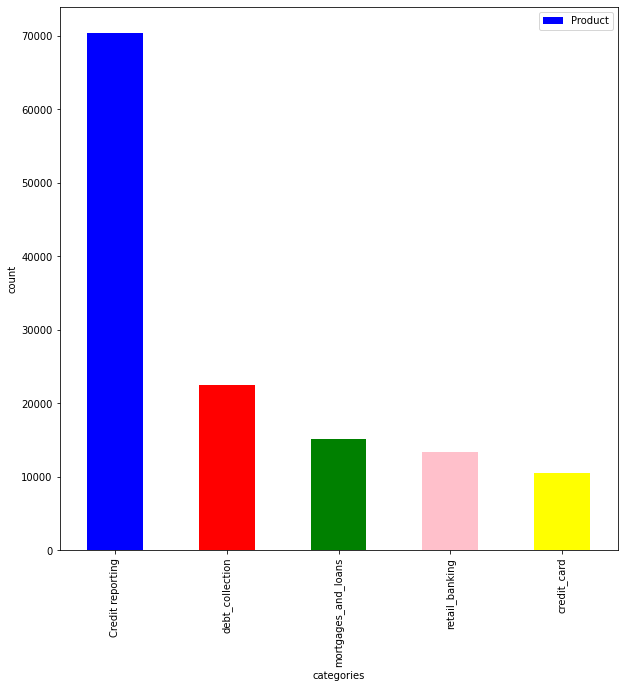

In [ ]:
import matplotlib.pyplot as plt
nlp_data_filter.Product.value_counts().plot(kind='bar',figsize=(10,10),color=['blue', 'red', 'green', 'pink', 'yellow'])
plt.xlabel('categories')
plt.ylabel('count')
plt.legend()

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout,SimpleRNN
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import *

nltk.download('stopwords') 
stop_word_removal = stopwords.words('english')  
nlp_data_filter['Consumer complaint narrative'] = nlp_data_filter['Consumer complaint narrative'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word_removal))
nlp_data_filter['Consumer complaint narrative'] = nlp_data_filter['Consumer complaint narrative'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
nlp_data_filter['Consumer complaint narrative'] = nlp_data_filter['Consumer complaint narrative'].apply(lambda x: re.sub(' ', ' ', x))
nlp_data_filter['Consumer complaint narrative'] = nlp_data_filter['Consumer complaint narrative'].apply(lambda x: re.sub('x', '',x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
nlp_data_filter.head()

,Product,Consumer complaint narrative
77,debt_collection,i received collections notice dated // att...
130,Credit reporting,attn collections dept i submitting complaint r...
202,mortgages_and_loans,despite forbearance ended months ago lakeview/...
215,mortgages_and_loans,i made several payments deemed ineligible towa...
223,mortgages_and_loans,about three years ago i attempted assume grand...


In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
nlp_data_filter['Product']=le.fit_transform(nlp_data_filter['Product'])
X = nlp_data_filter['Consumer complaint narrative']
y = nlp_data_filter['Product']
X_train, X_test, y_train, y_test=  train_test_split(X,y, test_size=0.20, random_state=42)
X_train_final, X_dev, y_train_final, y_dev = train_test_split(X_train,y_train, test_size=0.20, random_state=42)

In [ ]:
print(nlp_data_filter['Product'].unique())

[2 0 3 1 4]


In [ ]:
maxlen = 250
max_features = 50000
oov_tok = '<OOV>'

In [ ]:
from keras.preprocessing.text import Tokenizer
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_final.tolist()+X_test.tolist()+X_dev.tolist())
train_X = tokenizer.texts_to_sequences(X_train_final.tolist())
test_X = tokenizer.texts_to_sequences(X_test.tolist())
dev_X = tokenizer.texts_to_sequences(X_dev.tolist())
word_index = tokenizer.word_index

In [ ]:
trunc_type = 'post'
padding_type = 'post' 
vocab_size=len(word_index)+1

In [ ]:
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=maxlen,padding=padding_type, truncating=trunc_type)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=maxlen,padding=padding_type, truncating=trunc_type)
dev_X = tf.keras.preprocessing.sequence.pad_sequences(dev_X, maxlen=maxlen,padding=padding_type, truncating=trunc_type)

In [ ]:
train_X

array([[  28,  152,    2, ...,    0,    0,    0],
       [   2,  616,  124, ...,    0,    0,    0],
       [   9,   71,   25, ...,    0,    0,    0],
       ...,
       [ 513,    9, 1002, ..., 1995,  709,  343],
       [   2,   18,   58, ...,    0,    0,    0],
       [   7,   16,    3, ...,    0,    0,    0]], dtype=int32)

In [ ]:
vocab_len=len(word_index)+1
emb_dim=100

In [ ]:
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np
train_labels = to_categorical(np.asarray(y_train_final))
test_labels = to_categorical(np.array(y_test))
dev_labels=to_categorical(np.array(y_dev))
train_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## This is our Baseline Model RNN(Recurrent Nueral Network)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout,SimpleRNN
from tensorflow.keras.preprocessing import text, sequence 
import tensorflow as tf
Baseline_model = Sequential()
Baseline_model.add(Embedding(vocab_size, emb_dim, input_length=maxlen,trainable = False))
Baseline_model.add(SimpleRNN(64, return_sequences=False))
Baseline_model.add(Dropout(0.2))
Baseline_model.add(Dense(5, activation = 'softmax'))
Baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(Baseline_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5631700   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 5,642,585
Trainable params: 10,885
Non-trainable params: 5,631,700
_________________________________________________________________
None


In [ ]:
batch_size = 256
epochs  = 10
hisrnntory = Baseline_model.fit(train_X, train_labels,validation_data=(dev_X, dev_labels),batch_size = batch_size, epochs = epochs)

Epoch 1/10
331/331 [==============================] - 48s 138ms/step - loss: 0.4327 - accuracy: 0.5290 - val_loss: 0.4195 - val_accuracy: 0.5361
Epoch 2/10
331/331 [==============================] - 45s 137ms/step - loss: 0.4235 - accuracy: 0.5322 - val_loss: 0.4173 - val_accuracy: 0.5380
Epoch 3/10
331/331 [==============================] - 45s 137ms/step - loss: 0.4220 - accuracy: 0.5336 - val_loss: 0.4184 - val_accuracy: 0.5368
Epoch 4/10
331/331 [==============================] - 45s 137ms/step - loss: 0.4213 - accuracy: 0.5346 - val_loss: 0.4169 - val_accuracy: 0.5381
Epoch 5/10
331/331 [==============================] - 46s 138ms/step - loss: 0.4206 - accuracy: 0.5354 - val_loss: 0.4168 - val_accuracy: 0.5393
Epoch 6/10
331/331 [==============================] - 46s 138ms/step - loss: 0.4206 - accuracy: 0.5351 - val_loss: 0.4163 - val_accuracy: 0.5402
Epoch 7/10
331/331 [==============================] - 45s 137ms/step - loss: 0.4204 - accuracy: 0.5356 - val_loss: 0.4162 - val_ac

In [ ]:
baseline_model_prediction = Baseline_model.predict(test_X)
#predicted_bi_lstm
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, baseline_model_prediction.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, baseline_model_prediction.round()))

precision: [0.54477641 0.         0.94827586 0.         0.        ]
recall: [0.98656199 0.         0.01211988 0.         0.        ]
fscore: [0.70194243 0.         0.02393386 0.         0.        ]
support: [14139  2093  4538  3032  2631]
################################
              precision    recall  f1-score   support

           0       0.54      0.99      0.70     14139
           1       0.00      0.00      0.00      2093
           2       0.95      0.01      0.02      4538
           3       0.00      0.00      0.00      3032
           4       0.00      0.00      0.00      2631

   micro avg       0.55      0.53      0.54     26433
   macro avg       0.30      0.20      0.15     26433
weighted avg       0.45      0.53      0.38     26433
 samples avg       0.53      0.53      0.53     26433



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
RNN_accy=accuracy_score(test_labels, baseline_model_prediction.round())
RNN_Recall=recall_score(test_labels, baseline_model_prediction.round(),average='micro')
RNN_Precision=precision_score(test_labels, baseline_model_prediction.round(),average='micro')
RNN_f1=f1_score(test_labels, baseline_model_prediction.round(),average='micro')
print(RNN_Precision)

0.5456883450882594


## LSTM(Long short term memory)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
Second_model = Sequential()
Second_model.add(Embedding(vocab_size, emb_dim, input_length=maxlen))
Second_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#lstm_model.add(Dropout(0.2))
Second_model.add(Dense(5, activation = 'softmax'))
Second_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(Second_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5631700   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 5,712,605
Trainable params: 5,712,605
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 256
epochs  = 10
history = Second_model.fit(train_X, train_labels,validation_data=(dev_X, dev_labels),batch_size = batch_size, epochs = epochs)

Epoch 1/10
331/331 [==============================] - 246s 736ms/step - loss: 0.4281 - accuracy: 0.5314 - val_loss: 0.4173 - val_accuracy: 0.5389
Epoch 2/10
331/331 [==============================] - 244s 736ms/step - loss: 0.4068 - accuracy: 0.5441 - val_loss: 0.3539 - val_accuracy: 0.5863
Epoch 3/10
331/331 [==============================] - 243s 735ms/step - loss: 0.3521 - accuracy: 0.5818 - val_loss: 0.3385 - val_accuracy: 0.5930
Epoch 4/10
331/331 [==============================] - 243s 734ms/step - loss: 0.3878 - accuracy: 0.5517 - val_loss: 0.3512 - val_accuracy: 0.6004
Epoch 5/10
331/331 [==============================] - 244s 736ms/step - loss: 0.3812 - accuracy: 0.5561 - val_loss: 0.4172 - val_accuracy: 0.5462
Epoch 6/10
331/331 [==============================] - 243s 734ms/step - loss: 0.3851 - accuracy: 0.5677 - val_loss: 0.3284 - val_accuracy: 0.6055
Epoch 7/10
331/331 [==============================] - 243s 735ms/step - loss: 0.3173 - accuracy: 0.6248 - val_loss: 0.2805 -

In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
Second_model_prediction = Second_model.predict(test_X)
#predicted_bi_lstm
precision, recall, fscore, support = score(test_labels, Second_model_prediction.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, Second_model_prediction.round()))

precision: [0.91813251 0.         0.65826734 0.47643979 0.53676838]
recall: [0.88598911 0.         0.6044513  0.09003958 0.40782972]
fscore: [0.90177447 0.         0.63021252 0.15145631 0.46349892]
support: [14139  2093  4538  3032  2631]
################################
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     14139
           1       0.00      0.00      0.00      2093
           2       0.66      0.60      0.63      4538
           3       0.48      0.09      0.15      3032
           4       0.54      0.41      0.46      2631

   micro avg       0.82      0.63      0.71     26433
   macro avg       0.52      0.40      0.43     26433
weighted avg       0.71      0.63      0.65     26433
 samples avg       0.63      0.63      0.63     26433



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
LSTM_accy=accuracy_score(test_labels, Second_model_prediction.round())
LSTM_recall=recall_score(test_labels, Second_model_prediction.round(),average='micro')
LSTM_precion=precision_score(test_labels, Second_model_prediction.round(),average='micro')
LSTM_f1=f1_score(test_labels, Second_model_prediction.round(),average='micro')


## Bi-directional LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding 
embedding_dim = 100  
# Model Training
Third_model = Sequential()
Third_model.add(Embedding(vocab_size, 
                   embedding_dim,
                   input_length=maxlen))
# Bidirectional LSTM 
Third_model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   
Third_model.add(GlobalMaxPool1D())
Third_model.add(Dense(5,activation='softmax'))  
Third_model.summary()
Third_model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5631700   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 32)          14976     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,646,841
Trainable params: 5,646,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = Third_model.fit(train_X, train_labels,validation_data=(dev_X, dev_labels), batch_size = batch_size, epochs = epochs)

Epoch 1/10
331/331 [==============================] - 16s 36ms/step - loss: 0.3244 - accuracy: 0.6617 - val_loss: 0.2393 - val_accuracy: 0.7681
Epoch 2/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1937 - accuracy: 0.8179 - val_loss: 0.1751 - val_accuracy: 0.8393
Epoch 3/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1547 - accuracy: 0.8610 - val_loss: 0.1591 - val_accuracy: 0.8489
Epoch 4/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1377 - accuracy: 0.8766 - val_loss: 0.1448 - val_accuracy: 0.8632
Epoch 5/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1281 - accuracy: 0.8849 - val_loss: 0.1401 - val_accuracy: 0.8695
Epoch 6/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1206 - accuracy: 0.8911 - val_loss: 0.1380 - val_accuracy: 0.8721
Epoch 7/10
331/331 [==============================] - 11s 34ms/step - loss: 0.1143 - accuracy: 0.8988 - val_loss: 0.1415 - val_accuracy:

In [ ]:
Bi_LSTM_prediction = Third_model.predict(test_X)
y_pred=np.argmax(Bi_LSTM_prediction, axis=1)
y_test=np.argmax(test_labels, axis=1)
#classes_x=np.argmax(predicted_bi_lstm,axis=1)
#predicted_bi_lstm
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     14139
           1       0.76      0.74      0.75      2093
           2       0.83      0.78      0.80      4538
           3       0.86      0.85      0.85      3032
           4       0.86      0.91      0.89      2631

    accuracy                           0.88     26433
   macro avg       0.84      0.84      0.84     26433
weighted avg       0.88      0.88      0.88     26433



In [ ]:
Bi_LSTM_accy=accuracy_score(y_test, y_pred)
Bi_LSTM_recall=recall_score(y_test, y_pred,average='micro')
Bi_LSTM_precsion=precision_score(y_test, y_pred,average='micro')
Bi_LSTM_F1=f1_score(y_test, y_pred,average='micro')
print(Bi_LSTM_F1)

0.8767071463700677


In [ ]:
!pip install PrettyTable

In [ ]:
from prettytable import PrettyTable
myTable = PrettyTable(["Model", "Accuracy", "Precision", "Recall","F1"])
myTable.add_row(["RNN", RNN_accy, RNN_Precision, RNN_Recall,RNN_f1])
myTable.add_row(["LSTM",LSTM_accy,LSTM_precion,LSTM_recall,LSTM_f1])
myTable.add_row(["biLSTM",Bi_LSTM_accy,Bi_LSTM_precsion,Bi_LSTM_recall,Bi_LSTM_F1])
print(myTable)


+--------+--------------------+--------------------+--------------------+--------------------+
| Model  |      Accuracy      |     Precision      |       Recall       |         F1         |
+--------+--------------------+--------------------+--------------------+--------------------+
|  RNN   | 0.529792305073204  | 0.5456883450882594 | 0.529792305073204  |  0.53762285012285  |
|  LSTM  | 0.6286081791699769 | 0.8151891281950645 | 0.6286081791699769 | 0.7098427887901572 |
| biLSTM | 0.8767071463700677 | 0.8767071463700677 | 0.8767071463700677 | 0.8767071463700677 |
+--------+--------------------+--------------------+--------------------+--------------------+
